# Predict interval boundaries on kss audio

In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import IPython
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Data Preparation
Create features


## Audio Info

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


## Character and Syllable Chunk Markers

In [83]:
chunk_dir = 'data/korean-single-speaker/kss_chunks'

chunk_char_df = pd.read_csv(f'{chunk_dir}/chunk_char.csv')
chunk_syl_df = pd.read_csv(f'{chunk_dir}/chunk_syl.csv')

display(chunk_char_df)
display(chunk_syl_df)

,char,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
128,ᅵ,1.78153,1.83571,data/korean-single-speaker/kss/1/1_0003.wav
129,ᆫ,1.83571,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
130,ᄃ,1.97293,1.98396,data/korean-single-speaker/kss/1/1_0003.wav
131,ᅡ,1.98396,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


,syl,start,stop,audio
0,0,0.00000,0.14298,data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...
67,이,1.45550,1.53270,data/korean-single-speaker/kss/1/1_0003.wav
68,아,1.53270,1.75352,data/korean-single-speaker/kss/1/1_0003.wav
69,낀,1.75352,1.97293,data/korean-single-speaker/kss/1/1_0003.wav
70,다,1.97293,2.19790,data/korean-single-speaker/kss/1/1_0003.wav


## Event Marker Analysis

### Event Marker Statistics

In [84]:
# chunk_char_df['ivl'] = chunk_char_df['stop'] - chunk_char_df['start']
# display(chunk_char_df[['ivl', 'start', 'stop']].describe())

# median interval may be used for feature audio length
# feat_audio_len_s = chunk_char_df['ivl'].median()
# print(f'Feature Audio Length: {feat_audio_len_s}')

## Event Marker Data

Dictionary of audio_file -> list of event marker times.


In [85]:
char_event_stop_dict = {}
syl_event_stop_dict = {}
audio_files_char = chunk_char_df['audio'].unique()
audio_files_syl = chunk_syl_df['audio'].unique()

# List of the unique audio file path/names
audio_files = np.unique(np.concatenate((audio_files_char, audio_files_syl)))

for audio_file in audio_files:
    char_stop_events = chunk_char_df[chunk_char_df['audio'] == audio_file]['stop'].values
    syl_stop_events = chunk_syl_df[chunk_syl_df['audio'] == audio_file]['stop'].values
    char_event_stop_dict[audio_file] = char_stop_events
    syl_event_stop_dict[audio_file] = syl_stop_events

print(char_event_stop_dict)
print(syl_event_stop_dict)

{'data/korean-single-speaker/kss/1/1_0000.wav': array([0.14298, 0.17326, 0.25143, 0.3011 , 0.39456, 0.49473, 0.52397,
       0.5717 , 0.66385, 0.71846, 0.73074, 0.7928 , 0.86105, 0.8947 ,
       0.94568, 0.98747, 1.00429, 1.05658, 1.12825, 1.20548, 1.24674,
       1.27921, 1.33187, 1.35667, 1.50828, 1.54819, 1.5778 , 1.73609,
       2.04869, 2.15518, 2.28461, 2.3443 , 2.37857, 2.45163, 2.53042,
       2.55297, 2.61609, 2.63233, 2.68239, 2.7029 , 2.76329, 2.86374,
       2.8825 , 2.95272, 3.14772, 3.1583 , 3.4173 , 3.52653]), 'data/korean-single-speaker/kss/1/1_0001.wav': array([0.0927 , 0.12765, 0.17218, 0.2192 , 0.2473 , 0.41173, 0.50644,
       0.57461, 0.59243, 0.64042, 0.70654, 0.81835, 0.83326, 0.95153,
       1.09444, 1.11834, 1.20856, 1.37623, 1.59665, 1.64288, 1.76991,
       1.89271, 1.99178, 2.06911, 2.15357, 2.19706, 2.26984, 2.40939,
       2.50919, 2.78858, 2.85241, 2.89864, 2.99798, 3.0465 , 3.09567,
       3.16021, 3.20729, 3.33246, 3.50541, 3.52027, 3.71327, 3.97218]), 

## Audio Data

* X - audio wav file
* y - time to next boundary
  * Given X and the event stop times
DF

i_start, i_stop, i_midpoint, event_offset, audio_dur, audio

In [86]:
window_size_s = 0.3
# window_stride_s = 0.005

In [87]:
# def find_nearest_event(t, event_list):
#     event_dists = abs(event_list - t)
#     nearest_event_idx = np.argmin(event_dists)
#     return event_list[nearest_event_idx]

# def a_round(val):
#     return round(val, 6) if isinstance(val, float) else val
#
# def create_audio_df(event_dict, filenames):
#     df_dict = {
#         'i_start': [],
#         'i_stop': [],
#         'i_midpoint': [],
#         'nearest_event': [],
#         'audio_dur': [],
#         'audio': []
#     }
#     for fn in filenames:
#         dur = event_dict[fn]['dur']
#         ptr = 0.0
#
#         while ptr < dur:
#             w_start = ptr
#             w_stop = ptr + window_size_s
#             w_midpoint = w_start + (w_stop - w_start)/2
#
#             nearest = find_nearest_event(w_midpoint, event_dict[audio_file]['events'])
#             # offset = nearest - w_midpoint
#             # offset_is_in_window = abs(offset) > window_size_s / 2
#             # event_offset_val = offset if offset_is_in_window  else None
#
#             df_dict['i_start'].append(a_round(w_start))
#             df_dict['i_stop'].append(a_round(w_stop))
#             df_dict['i_midpoint'].append(a_round(w_midpoint))
#             df_dict['nearest_event'].append(a_round(nearest))
#             # df_dict['event_offset'].append(a_round(event_offset_val))
#             df_dict['audio_dur'].append(dur)
#             df_dict['audio'].append(fn)
#
#             ptr = a_round(ptr + window_stride_s)
#
#     audio_df = pd.DataFrame.from_dict(df_dict)
#     audio_df['evt_dist'] = audio_df['nearest_event'] - audio_df['i_midpoint']
#     audio_df['valid_event'] = audio_df['evt_dist'].abs() < (window_size_s / 2)
#     return audio_df

# audio_char_df = create_audio_df(char_event_dict, audio_files)
# print(audio_char_df['valid_event'].value_counts())
# display(audio_char_df)
# print('----')
# audio_syl_df = create_audio_df(syl_event_dict, audio_files)
# print(audio_syl_df['valid_event'].value_counts())
# display(audio_syl_df)

## Feature Prep

X is slices of audio with window_size_s duration

y is valid_event boolean

TODO: Normalize the data across audio files


In [88]:
import math
from keras.preprocessing.sequence import pad_sequences
from scipy import stats
from sklearn.utils import shuffle


audio_dict = {}

def t_to_samps(sr, t):
    return int(math.ceil(t * sr))

def calc_dist_to_stop(wav, sr, stop_times):
    # index to track the current stop_time
    stop_idx = 0
    dist_to_stop = np.zeros(wav.shape).astype(int)
    for i in range(wav.shape[0]):
        dist = t_to_samps(sr, stop_times[stop_idx]) - i
        if dist < 0:
            stop_idx += 1
            dist = t_to_samps(sr, stop_times[stop_idx]) - i
        if dist < 0:
            raise Exception('Unable to calculate distace t next stop time')
        dist_to_stop[i] = dist
    return dist_to_stop

X = np.array([])
y = np.array([])
sr = None
for fn in audio_files:
    wav, sr = librosa.load(fn)
    # wav = np.pad(wav, int(window_size_s*sr), 'edge')
    dist_to_stop = calc_dist_to_stop(wav, sr, syl_event_stop_dict[fn])
    # audio_dict[fn] = {'sr': sr, 'wav': wav, 'dist_to_stop': dist_to_stop}
    X = np.concatenate([X, wav])
    sr = sr
    y = np.concatenate([y, dist_to_stop])
X=X.flatten()
print(X.shape)
print (y.shape)

# print(audio_dict['data/korean-single-speaker/kss/1/1_0000.wav'])
# print(audio_dict['data/korean-single-speaker/kss/1/1_0003.wav'])
# def pr_stats(a):
#     # stats_a = stats.describe(a)
#     print(f'shape: {a.shape}')
#     print(f'global max: {np.amax(a)}')
#     print(f'global min: {np.amin(a)}')
#     print(f'global mean: {np.mean(a)}')
#     print(f'global median: {np.median(a)}')
#
# def ls_of_a_stats(a):
#     types = [type(ls) for ls in a]
#
#     print(f'Outer Type: {type(a)}')
#     print(f'Inner Types: {set(types)}')
#
#     print(f'Outer Len: {len(a)}')
#     shapes = [ls.shape for ls in a]
#     print(f'Inner Shapes: {set(shapes)}')
#
#     # stats_ls = [stats.describe(ls) for ls in a]
#     # print(f'stats: {set(stats_ls)}')
#
# def pad_trunc(a, size):
#     # print(f'pad_trunc input, a shape: {a.shape}, fix to size: {size}')
#     if len(a) < size:
#         pad_size = size - len(a)
#         a = np.pad(a, pad_size, 'edge')
#     if len(a) > size:
#         a = a[0:size]
#     # print(f'pad_trunc output, a shape: {a.shape}')
#     return a
#
# class AudioPrep:
#
#     def __init__(self, wav, sr, pad_s=(0,0)):
#             self.sr = sr
#             self.pad_samps = tuple(map(self.t_to_samps, pad_s))
#             self.wav = np.pad(wav, self.pad_samps, 'edge')
#
#     def t_to_samps(self, t):
#             return int(math.ceil(t * self.sr))
#
#     # ivls is numpy array of  [start, stop] timestamps
#     def slice_by_time(self, ivls):
#         idxs = (ivls * self.sr).astype(int)
#         slices = np.asarray([self.wav[rs[0]:rs[1]] for rs in idxs])
#         # [print([pr_stats(slice) for slice in slices])]
#         return slices
#
#     def samps_to_next_event(self, event_times):
#         event_idxs = (event_times * self.sr).astype(int)
#         print(event_idxs.shape)
#         print(event_idxs)
#
# def get_ivls_np(audio_df, f):
#     return audio_df[audio_df['audio'] == f][['i_start', 'i_stop']].values
#
# def get_events_np(audio_df, f):
#     return audio_df[audio_df['audio'] == f][['i_stop']]
#
# def get_X(audio_wav_dict, audio_df, f):
#     print(audio_df[audio_df['audio'] == f].head())
#     events = get_events_np(audio_char_df, f)
#     # print(f'{f} events: {events}')
#     ap = AudioPrep(audio_wav_dict[f]['wav'], audio_wav_dict[f]['sr'], (0,window_size_s))
#     # ap.samps_to_next_event(events)
#     ivs = get_ivls_np(audio_df, f)
#     return ap.slice_by_time(ivs)
#
# nested_x = [get_X(audio_dict, audio_char_df, fn) for fn in audio_files]
#
#
# x_ls = [val for x_partial in nested_x for val in x_partial]
# ls_of_a_stats(x_ls)
#
# x_shapes = np.asarray([x_.shape for x_ in x_a ])
#
#
# X = pad_sequences(x_a, padding='post', dtype='float32')
# pr_stats(X)
# # X = (X - np.min(X))/np.ptp(X)
# # print(f'X shape: {X.shape}')
#
#
# y = audio_char_df['valid_event'].values.astype(float)
# print (f'y shape: {y.shape}')
#
#
# # pr_stats(X)
# # X, y = shuffle(X, y, random_state=42)
# #

# # nested_stats(X)

(255015,)
(255015,)


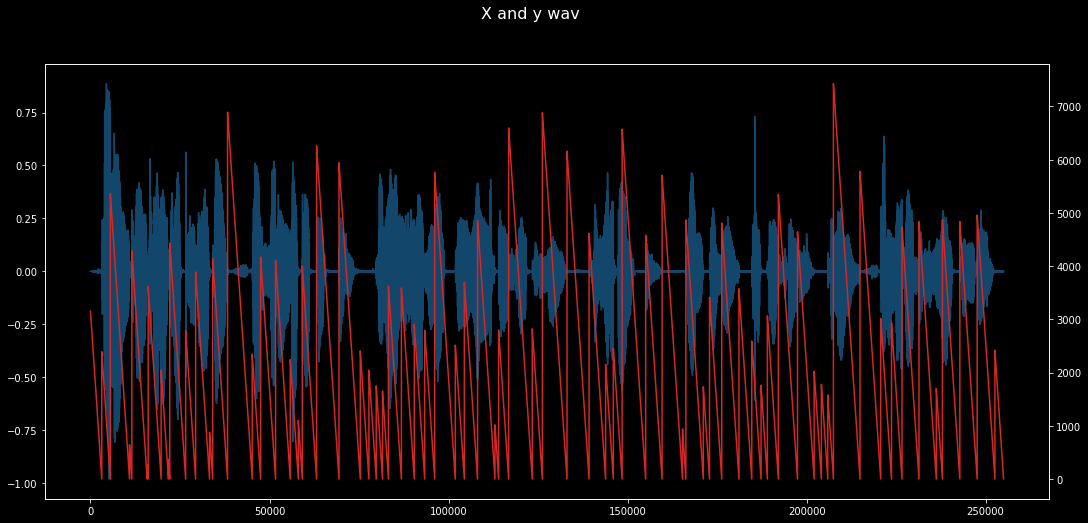

In [89]:
#
fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('X and y wav', fontsize=16)
# ax1.plot(np.max(X, axis=0))
ax1.plot(X, color='tab:blue', alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(y, color='tab:red', alpha=1)
# ax1.scatter(x_, np.concatenate(X), alpha=1)
# ax1.scatter(x_, y-0.5, alpha=0.25)
plt.show()


## CNN Model

In [90]:

from keras.models import Sequential
from keras import layers

from keras.optimizers import RMSprop

print(X.shape)
print(y.shape)
seq_length = int(math.ceil(window_size_s * sr))
truncate_by = X.shape[0] % seq_length
X = X[0:-truncate_by]
y[0:-truncate_by]
print(truncate_by)
print(seq_length)
print(X.shape)
print(y.shape)

(255015,)
(255015,)
3645
6615
(251370,)
(255015,)


In [91]:
from keras.optimizers import Adam

num_features = 1
X = X.reshape(-1, seq_length, 1)
print(X.shape)
print(y.shape)

#parameters
kernel_size = 8
batch_size = 256
epochs = 40
# optimizer=RMSprop(lr=1e-4)
# optimizer='rmsprop'
optimzer = Adam(learning_rate=1e-4)
strides=16


model = Sequential()
# model.add(layers.Embedding(X.shape[0], kernel_size, input_length=input_length))
model.add(layers.Conv1D(1024, kernel_size, activation='relu', strides=strides, input_shape=(seq_length, num_features)))
model.add(layers.AveragePooling1D(24))
model.add(layers.Conv1D(2048, kernel_size, activation='relu', strides=strides))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='linear'))

model.summary()

model.compile(optimizer=optimizer,
              loss='mean_absolute_error',
              metrics=['mean_absolute_error', 'acc'])

history = model.fit(X, y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2)


(38, 6615, 1)
(255015,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 413, 1024)         9216      
_________________________________________________________________
average_pooling1d_16 (Averag (None, 17, 1024)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1, 2048)           16779264  
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2049      
Total params: 16,790,529
Trainable params: 16,790,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 3138.5000 - me

RNN Model

In [ ]:
# # Parameters
# timesteps = 8
# # optimizer=RMSprop(lr=1e-4)
# optimizer='rmsprop'
#
#
# # Model Input
# features = X.shape[1]
# input_shape = (timesteps, features)
#
# model = Sequential()
# model.add(layers.LSTM(32, input_shape=input_shape, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
#
# model.summary()
#
# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['acc'])
#
# history = model.fit(X, y,
#                     epochs=10,
#                     batch_size=16,
#                     validation_split=0.2)

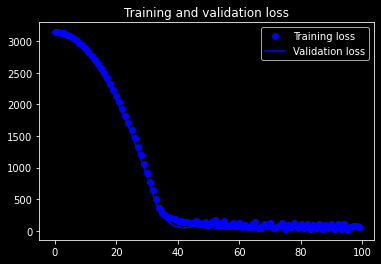

In [67]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
#
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [72]:
# print(X)
X_test = X[[15, 25]]
print(X_test.shape)
y_test = model.predict_classes(X_test)
#
# print(y_test.reshape(1,-1))

print(y_test.shape)
print(y_test)

(2, 6615, 1)
(2, 1)
[[1]
 [1]]


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


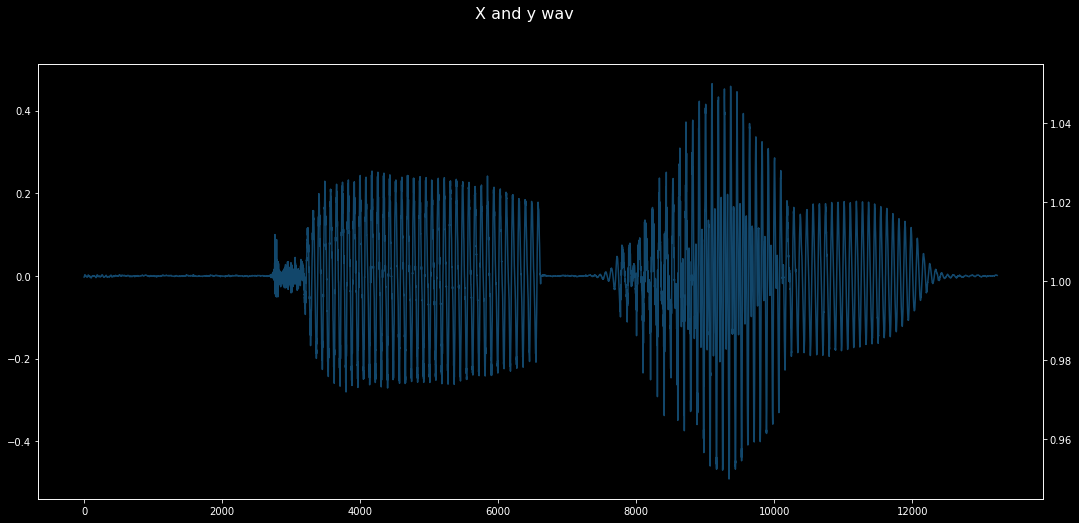

In [71]:
fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('X and y wav', fontsize=16)
# ax1.plot(np.max(X, axis=0))
ax1.plot(X_test.flatten(), color='tab:blue', alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(y_test.flatten(), color='tab:red', alpha=1)
# ax1.scatter(x_, np.concatenate(X), alpha=1)
# ax1.scatter(x_, y-0.5, alpha=0.25)
plt.show()




In [ ]:



data_files = chunk_char_df['audio'].unique()
sr_ = None
audio_ = None
for wv in data_files:
    fn = f'{wv}'
    print(f'Data file to analyze: {fn}')
    print(f'current sample rate: {sr_}')
    new_audio_, new_sr_ = librosa.load(fn)
    print(f"latest sample rate: {new_sr_}")
    print(f'new_audio_ shape: {new_audio_.shape}')
    if sr_ is None:
        sr_ = new_sr_
    else:
        assert(new_sr_ == sr_)

    if audio_ is None:
        audio_ = new_audio_
    else:
        audio_ = np.concatenate((audio_, new_audio_))
    print('new audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(new_audio_), np.max(new_audio_)))
    print('full audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(audio_), np.max(audio_)))





ap = AudioPrep(sr_, 0.75)
print(ap.size)
_b = ap.resize(audio_)

print(_b.shape)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,4), tight_layout=True)
fig.suptitle('Waveforms', fontsize=16)
ax1.set_title(f'librosa ({sr_})')
ax1.plot(audio_)

## Event Marker (Boundaries) Dataset
# audio | event_idx



In [ ]:
# boundary_audio
# boundary_idx | audio_data

# boundary_mfcc
# boundry_idx | mfcc_data
